In [24]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from scipy.sparse import csr_matrix
from sklearn.linear_model import Ridge
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import mean_squared_error
import re
from nltk.corpus import stopwords
import pymorphy2

In [25]:
test = pd.read_csv('ml5/test.csv',sep = ';',na_values = 'None')
train = pd.read_csv('ml5/train.csv',sep = ';',na_values = 'None')
y = train.pop('cardio')

In [26]:
train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,18393,2,168,62.0,110,80,1,1,0,0,1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
id             30000 non-null int64
age            30000 non-null int64
gender         30000 non-null int64
height         30000 non-null int64
weight         30000 non-null float64
ap_hi          30000 non-null int64
ap_lo          30000 non-null int64
cholesterol    30000 non-null int64
gluc           30000 non-null int64
smoke          26970 non-null float64
alco           26969 non-null float64
active         27103 non-null float64
dtypes: float64(4), int64(8)
memory usage: 2.7 MB


In [29]:
test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0.0,0.0,1.0
1,6,19042,2,170,69.0,130,90,1,1,NaN,0.0,1.0
2,7,20432,1,160,70.0,120,75,1,1,0.0,0.0,0.0
3,10,18133,2,185,94.0,130,90,1,1,NaN,0.0,1.0
4,11,16093,2,170,76.0,120,80,1,1,0.0,0.0,1.0


In [30]:
import pandas as pd;
import random
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
%matplotlib inline

In [31]:
dtrain = xgb.DMatrix(train, label=y)
dtest = xgb.DMatrix(test)

In [38]:
%%time
param = {'max_depth':4, 'eta':0.01, 'silent':0,
         'objective':'binary:logistic',
         'subsample':0.8,
         'colsample_bytree':0.8,
         'seed':202,
         #'scale_pos_weight':scale_pos_weight   с этой штуковиной почему-то результат был на мнооого хуже
         'updater':'grow_gpu'
        }
param['eval_metric'] = 'logloss'
trees = 5000
cv = xgb.cv(param, dtrain, metrics=('logloss'), show_stdv=True,
            num_boost_round=trees,nfold=5,early_stopping_rounds = 50)

CPU times: user 3min 8s, sys: 8.54 s, total: 3min 16s
Wall time: 50.8 s


test-logloss-mean     0.539636
test-logloss-std      0.001427
train-logloss-mean    0.529732
train-logloss-std     0.000630
Name: 1168, dtype: float64


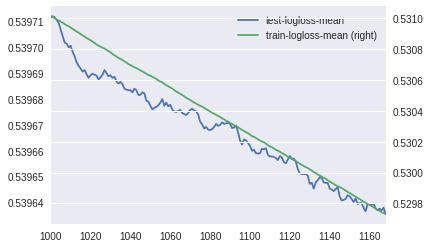

In [40]:
cv[1000:].plot(y=['test-logloss-mean', 'train-logloss-mean'], secondary_y='train-logloss-mean')
print cv.loc[cv['test-logloss-mean'].argmin()]
trees = cv['test-logloss-mean'].argmin()

In [41]:
%%time
bst = xgb.train(param,dtrain,trees)
a = pd.DataFrame()

CPU times: user 56.9 s, sys: 1.82 s, total: 58.7 s
Wall time: 30.3 s


In [42]:
a['y'] = bst.predict(dtest)
a.to_csv('xgb.csv', index = False, header = False)